In [107]:
"""
Created by Flavio Martinelli at 13:09 18/05/2020
"""
import colorama
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import maze_plot as mplot
import tensorflow as tf
import tensorflow_probability as tfp
import tf_agents.networks.network as tf_network

from tqdm.notebook import trange, tqdm
from tf_agents.environments import utils
from tf_agents.environments import tf_py_environment, batched_py_environment
from tf_agents.policies import actor_policy
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.specs import array_spec

from maze_tf import Maze2D

### Create environment list

State: 	 2
Reward position: 6


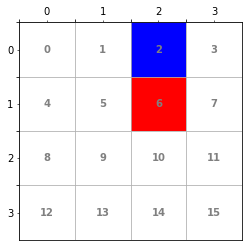

In [108]:
size=(4,4)

environment = batched_py_environment.BatchedPyEnvironment([Maze2D(size, walls=True, gamma=0.9) for e in range(10)])
environment = tf_py_environment.TFPyEnvironment(environment)

# Reset environment and creates first initial_time_step of trajectory
initial_time_step = environment.reset()
print(f"State: \t {initial_time_step.observation[0,0].numpy()}")
print(f"Reward position: {environment.pyenv.envs[0].reward_pos}")

fig, ax = mplot.base_fig(size)
mplot.draw_cell_numbers(ax, environment.pyenv.envs[0].maze_array)
mplot.color_square(ax, environment.pyenv.envs[0].get_coordinates(environment.pyenv.envs[0]._state), 'b')
mplot.color_square(ax, environment.pyenv.envs[0].get_coordinates(environment.pyenv.envs[0].reward_pos), 'r')

In [109]:
environment.pyenv.envs

### Useful specs

In [110]:
action_shape = environment.action_spec().maximum + 1
value_shape = 1
print(action_shape)
print(value_shape)

time_step_spec = ts.time_step_spec(environment.observation_spec())
action_spec = environment.action_spec()
max_one_hot = np.prod(size)
print(time_step_spec)
print(action_spec)
print(max_one_hot)

4
1
TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(1,), dtype=tf.int32, name='observation', minimum=array(0), maximum=array(15)))
BoundedTensorSpec(shape=(1,), dtype=tf.int32, name='action', minimum=array(0), maximum=array(3))
16


### Linear Readout Network

In [111]:
class ActorLinearReadout(tf_network.Network):

    def __init__(self, max_one_hot, output_shape):
        self.max_one_hot = max_one_hot
        input_state_spec = tf.TensorSpec(shape=(self.max_one_hot), dtype=np.int32, name='one_hot_obs')

        super(ActorLinearReadout, self).__init__(
            input_tensor_spec=input_state_spec,
            state_spec=(),
            name='LinearReadout')
        
        self._sub_layers = [tf.keras.layers.Dense(output_shape,
                                                  activation=None, kernel_initializer='zero',
                                                  use_bias=False)]

    def call(self, observations, step_type, network_state):
        del step_type
        
        # Transform int32 state into one_hot encoded tensor
        output = tf.one_hot(indices=observations, depth=self.max_one_hot, dtype=tf.float32, axis=-1)
        
        for layer in self._sub_layers:
            output = layer(output)
        output = tf.nn.softmax(output)
        
        actions_categorical_dist = tfp.distributions.Categorical(probs=output, dtype=tf.int32)
        
        # Scale and shift actions to the correct range if necessary.
        return actions_categorical_dist, network_state
    
class CriticLinearReadout(tf_network.Network):

    def __init__(self, max_one_hot, output_shape):
        self.max_one_hot = max_one_hot
        input_state_spec = tf.TensorSpec(shape=(self.max_one_hot), dtype=np.int32, name='one_hot_obs')

        super(CriticLinearReadout, self).__init__(
            input_tensor_spec=input_state_spec,
            state_spec=(),
            name='LinearReadout')
        
        self._sub_layers = [tf.keras.layers.Dense(output_shape,
                                                  activation=None, kernel_initializer='zero',
                                                  use_bias=False)]

    def call(self, observations, step_type, network_state):
        del step_type
        
        # Transform int32 state into one_hot encoded tensor
        output = tf.one_hot(indices=observations, depth=self.max_one_hot, dtype=tf.float32, axis=-1)

        for layer in self._sub_layers:
            output = layer(output)
                
        # Scale and shift actions to the correct range if necessary.
        return tf.squeeze(output, axis=-1), network_state

### Define networks and policies

In [112]:
action_net = ActorLinearReadout(max_one_hot, action_shape)
value_net = CriticLinearReadout(max_one_hot, value_shape)

actor = actor_policy.ActorPolicy(time_step_spec=time_step_spec, action_spec=action_spec, actor_network=action_net)

value_net.create_variables()

### Define training loop parameters

In [113]:
episode_lenght = tf.constant(5)
gamma = 0.9
batch_size = 1
lr = 0.02
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

### Define episode collection driver

The driver will load actions and observations to the corresponding lists, reinitialize them every new episode.

When calling driver.run remember to specify the initial_time_step which should correspond to the initial state of each maze.

In [117]:
# Pre compute triangular matrix of gamma powers, useful to compute future return
increasing_t_steps = tf.range(episode_lenght, dtype=tf.float32)
returns = (tf.ones(episode_lenght)*gamma)**increasing_t_steps
rolling=[]
for r in range(episode_lenght):
    rolling.append(tf.roll(returns, r, axis=0))
gamma_matrix = tf.linalg.band_part(tf.stack(rolling, axis=0), 0, -1)

buff = []
observations = []
actions = []
rewards = []
collect_obs = lambda rb: observations.append(rb.observation)
collect_act = lambda rb: actions.append(rb.action)
collect_rew = lambda rb: rewards.append(rb.reward)
env_steps = tf_metrics.EnvironmentSteps()

observers = [buff.append, collect_obs, collect_act, collect_rew, env_steps]
driver = dynamic_episode_driver.DynamicEpisodeDriver(environment, actor, observers, num_episodes=1)
# driver = dynamic_step_driver.DynamicStepDriver(environment, actor, observers, num_steps=episode_lenght)

In [118]:
driver.run(time_step=initial_time_step)

(TimeStep(step_type=<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 1, 0, 2, 1, 1])>, reward=<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)>, discount=<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1. , 0. , 0.9, 0.9], dtype=float32)>, observation=<tf.Tensor: shape=(10, 1), dtype=int32, numpy=
 array([[ 0],
        [10],
        [ 4],
        [11],
        [ 2],
        [ 0],
        [11],
        [ 1],
        [15],
        [ 6]])>),
 ())

In [120]:
buff

[Trajectory(step_type=<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>, observation=<tf.Tensor: shape=(10, 1), dtype=int32, numpy=
 array([[ 2],
        [15],
        [ 0],
        [11],
        [ 0],
        [ 1],
        [ 9],
        [ 3],
        [ 1],
        [11]])>, action=<tf.Tensor: shape=(10, 1), dtype=int32, numpy=
 array([[1],
        [2],
        [2],
        [3],
        [3],
        [1],
        [3],
        [1],
        [1],
        [3]])>, policy_info=(), next_step_type=<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 1, 1, 1, 1, 2, 1, 0, 1])>, reward=<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>, discount=<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1. , 1. , 0.9, 0.9, 0.9, 0.9, 0. , 0.9, 1. , 0.9], dtype=float32)>),
 Trajectory(step_type=<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 1, 1, 1, 1, 2, 1, 0, 1])>, observation=<tf.Tensor: shape=(10, 

### Train

In [8]:
@tf.function(experimental_relax_shapes=False)
def loss_fun(value_net, action_net, observations, actions, rewards, returns, gamma_matrix, optimizer):
    
    # to substitute with proper batching
    returns = tf.expand_dims(tf.linalg.matvec(gamma_matrix, rewards), 0)
    
    # Compute losses
    with tf.GradientTape() as tape:

        # critic loss
        v_estimates, _ = value_net(observations, (), ())
        critic_loss = tf.reduce_sum((v_estimates - returns)**2)

        # actor loss
        d, _ = action_net(observations, (), ())
        gather_indices = tf.stack([tf.range(tot_time_steps, dtype=tf.int32), actions], axis=1)

        log_pi = tf.math.log(tf.gather_nd(tf.squeeze(d.probs, axis=0), gather_indices))

        actor_loss = tf.reduce_sum(log_pi*tf.stop_gradient(value_net(observations, (), ())[0] - returns))

        loss = critic_loss + actor_loss

        grads = tape.gradient(loss, action_net.trainable_weights + value_net.trainable_weights)
        optimizer.apply_gradients(zip(grads, action_net.trainable_weights + value_net.trainable_weights))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


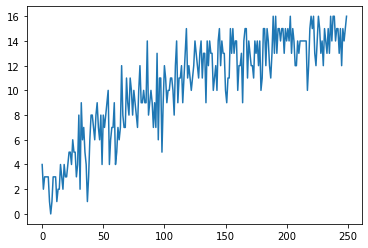

In [9]:
trace = []
tot_episodes = 250

with trange(tot_episodes, desc='inner loop', position=1, leave=False) as t:
    for e in t:
        # Collect episode
        observations = []
        actions = []
        rewards = []
        env_steps.reset()

        initial_time_step, _ = driver.run(time_step=initial_time_step)
                
        observations = tf.stack(observations[:episode_lenght], axis=1)[:,:,0]
        actions = tf.squeeze(tf.stack(actions[:episode_lenght], axis=1))
        rewards = tf.squeeze(tf.stack(rewards[:episode_lenght], axis=1))
        
        tot_time_steps = env_steps.result()
        
        loss_fun(value_net, action_net, observations, actions, rewards, returns, gamma_matrix, optimizer)
       
        trace.append(tf.reduce_sum(rewards).numpy())
        t.set_postfix(tot_reward=tf.reduce_sum(rewards).numpy())                        


plt.plot(trace)

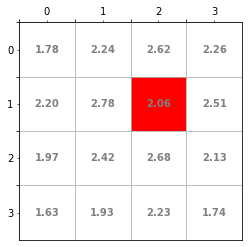

In [10]:
v_vals = np.array([f"{v[0]:.2f}"for v in value_net.trainable_weights[0].numpy()]).reshape(4,4)
fig, ax = mplot.base_fig(size)
mplot.draw_cell_numbers(ax, v_vals)
mplot.color_square(ax, environment.pyenv.envs[0].get_coordinates(environment.pyenv.envs[0].reward_pos), 'r')